In [ ]:
#|hide
#| eval: false
! [ -e /content ] && pip install -Uqq fastgs  # upgrade on colab

# Welcome to fastgs

> Geospatial (Sentinel2 Multi-Spectral) support for fastai

## Introduction

**This library is currently in _alpha_, neither the functionality nor the API is stable**. Feedback / PR's welcome!

This library provides geospatial multi-spectral image support for fastai. FastAI already has extensive support for RGB images in the pipeline. I try to achieve feature parity for multi-spectral images with this library, specifically in the context of Sentinel 2 geospatial imaging.

## Demo Notebooks

Complete examples are provided in the following notebooks

1. working with a netCDF sample [KappaSet](https://www.kaggle.com/code/restlessronin/netcdf-demo-fastai-using-fastgs). demo code for brightness factor calculation by [@wrignj08](https://github.com/wrignj08). Shows how to load images with all channels stored in a single netCDF file.
2. working with the kaggle [38-cloud/95-cloud landsat dataset](https://www.kaggle.com/code/restlessronin/cloud95-fastai-with-fastgs-multispectral-support). Shows how to load images stored in a "single channel per file" format (seems to be the common case).
2. working on a segmentation problem with a [Sentinel 2 dataset](https://www.kaggle.com/code/restlessronin/lila-sentinel-2-segmentation-with-fastai)

These are boths works in progress and optimized to display the features of the library, rather than the best possible results. Even so, the "cloud 95" notebook is providing results comparable to other hiqh quality notebooks on the same dataset.

## Install

```sh
pip install -Uqq fastgs
```

```sh
conda install -c restlessronin fastgs
```

## Multi-spectral visualization

One key problem that is solved is visualization of multi-spectral data, which has more than the three R, G, B channels.

We introduce a new category of pytorch tensor, `TensorImageMS`, that shows multiple images. In addition to the normal RGB image, it handles extra channels by displaying them as additional images, either in sets of false-colour RGB images, or as 'monochrome' images (one per channel).

There is also [experimental support](07a_vision.core.ipynb#animating-multiple-images) (not integrated into the API yet) for mapping multi-spectral images to an animation of multiple images. Feedback on it's usefulness is welcome!

The first use-case is Sentinel 2 images, which are naturally "dark". There is a provision to provide "brightening" multipliers during display, customizable per channel.

## Image data class

A high-level API, `MSData` is exposed that knows how to load multispectral images given some parameters.

In [ ]:
from fastgs.multispectral import *

The following code creates a class that can load 11 Sentinel 2 channels into a `TensorImageMS`. The first parameter is a descriptor that provides mapping from Sentinel 2 channels to brightening factors and other parameters specific to the inputs. This will generally be tailored to your image dataset.

In [ ]:
from fastgs.test.io import * # defines file naming and io for our test samples

sentinel2 = createSentinel2Descriptor()

snt12_imgs = MSData.from_files(
    sentinel2,
    # B04 and B02 are transposed so that the first 3 channels are natural R,G,B channels
    ["B04","B03","B02","B05","B06","B07","B08","B8A","B11","B12","AOT"],
    [["B04","B03","B02"],["B07","B06","B05"],["B12","B11","B8A"],["B08"]],
    get_channel_filenames,
    read_multichan_files
)

The second parameter is a list of ids of channel to be loaded into the image tensor, in the order in which they are loaded.

The third parameter is a list of 4 channel lists. Each channel list describes one image that will be displayed. The lists that have 3 channel ids will map those channels to the R,G,B inputs of a "false-colour" image. Lists with a single channel id will be mapped to monochrome images.

In this example, we will display 4 images per MS image. The first maps the "real" RGB channels (B04, B03, B02) of Sentinel 2 data to an RGB image, which makes this a true-colour image. The second image maps channels B07, B06, B05 to a false-colour image. Likewise the third image maps B12, B11, B8A to a false-colour image. Finally the one remaining channel B08 is mapped to a monochrome image. Thus all the channels in the image are displayed.

The fourth parameter is a function that maps channel id's to filenames that provide the image data for a single channel. The final parameter is an IO function that loads a complete TensorImageMS given the list of files corresponding to individual channels.

## Image display

The simplest use of the high-level wrapper class is to load an indvidual MS image. 

[<AxesSubplot:title={'center':'B04,B03,B02'}>,
 <AxesSubplot:title={'center':'B07,B06,B05'}>,
 <AxesSubplot:title={'center':'B12,B11,B8A'}>,
 <AxesSubplot:title={'center':'B08'}>]

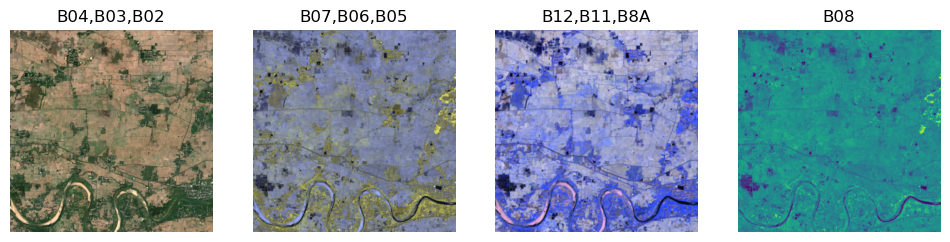

In [ ]:
img12 = snt12_imgs.load_image(66)
img12.show()

Note that the single MS image is displayed as 4 images, each corresponding to one of the channel lists we provided. The first image is the true-colour image, the next 2 are false colour, and the final one is monochrome.

## High level wrapper `FastGS` for semantic segmentation

We also provide a high-level wrapper `FastGS` which generates fastai dataloaders and learners for semantic segmentation using unets. Providing support for other models and for classification should be straightforward.

### `MaskData`

Continuing our example, we provide mask information using a wrapper class for segmentation mask loading (this is analogous to the `MSData` class, but for 'normal' `TensorImage`s).

In [ ]:
msks = MaskData.from_files("LC",get_channel_filenames,read_mask_file,["non-building","building"])

### `MSAugment`

We also provide a wrapper class that can specify which (if any) augmentations to use during training and validation, using the albumentations library (which works for multi-spectral data).

In [ ]:
import albumentations as A

Here we just use demo augmentations

In [ ]:
augs = MSAugment(train_aug=A.Rotate(p=1),valid_aug=A.HorizontalFlip(p=0.33))

Now we create the actual high level wrapper

In [ ]:
fastgs = FastGS(snt12_imgs,msks,augs)

Create a datablock and a data loader

In [ ]:
db = fastgs.create_data_block()
dl = db.dataloaders(source=[66]*10,bs=8) # repeat the sample image 10 times

Now we can see the visualization support in action. Let's look at some training and validation batches (with augmentation). Each row shows the image in 4 columns and the mask in the 5th.

In [ ]:
from fastai.vision.all import *
from fastgs.vision.data import *
from fastgs.vision.learner import *
from fastgs.vision.augment import *

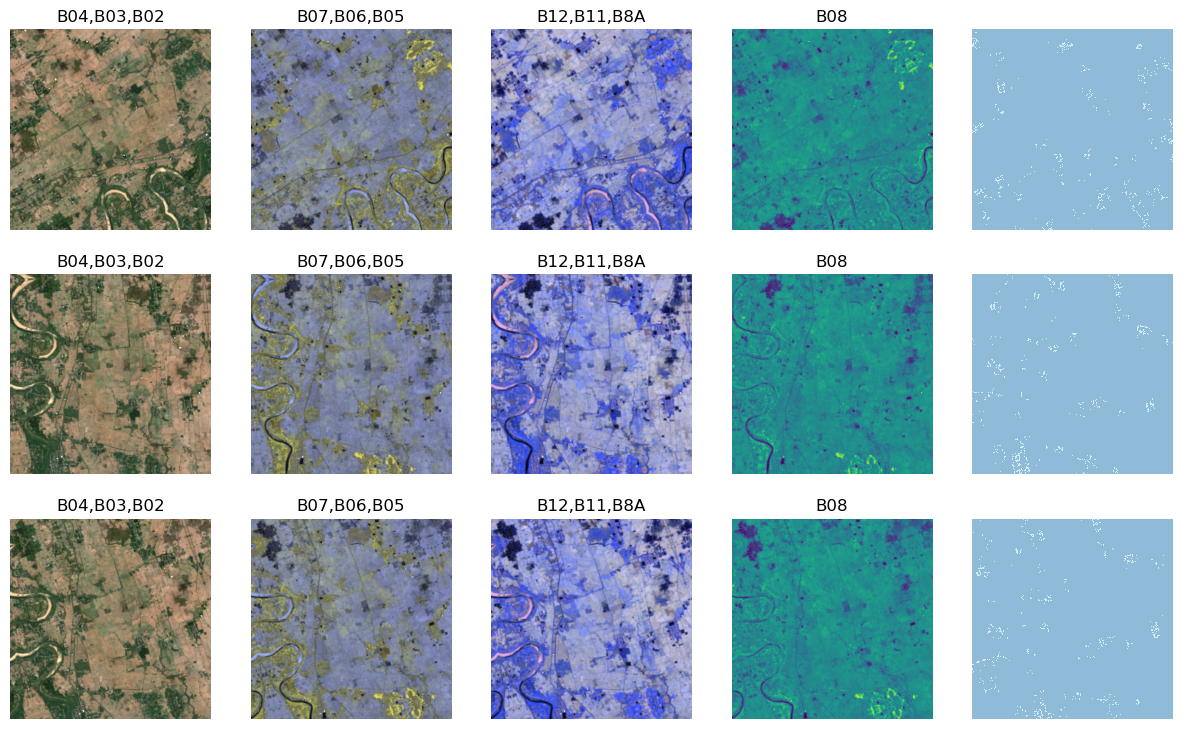

In [ ]:
dl.train.show_batch(max_n=3,mskovl=False) # don't overlay mask

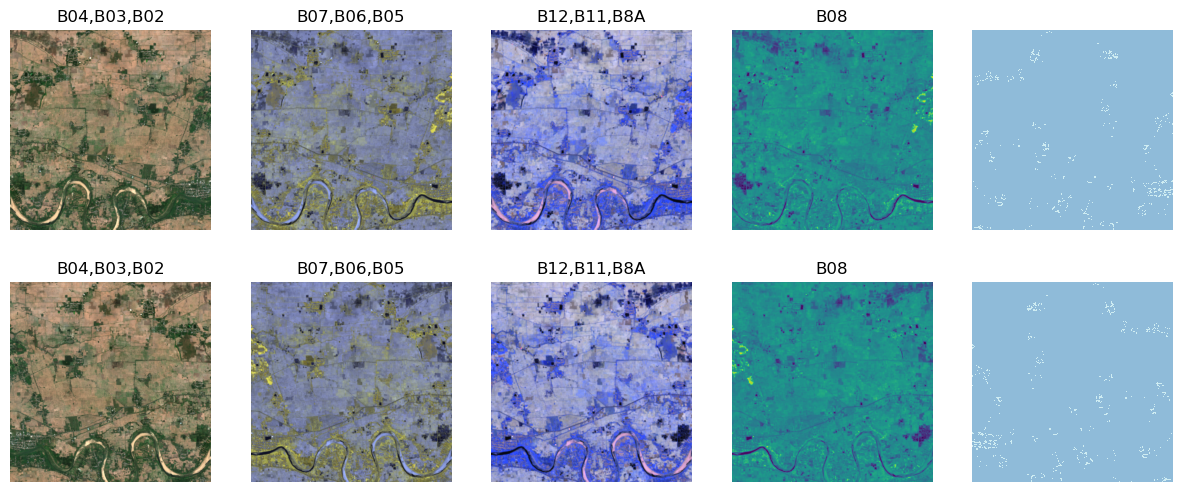

In [ ]:
dl.valid.show_batch(mskovl=False)

We create and train a unet learner and look at results. Image is in first 4 columns, mask in the 5th and prediction in the 6th.

/opt/homebrew/Caskroom/miniforge/base/envs/fastgs/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/fastgs/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


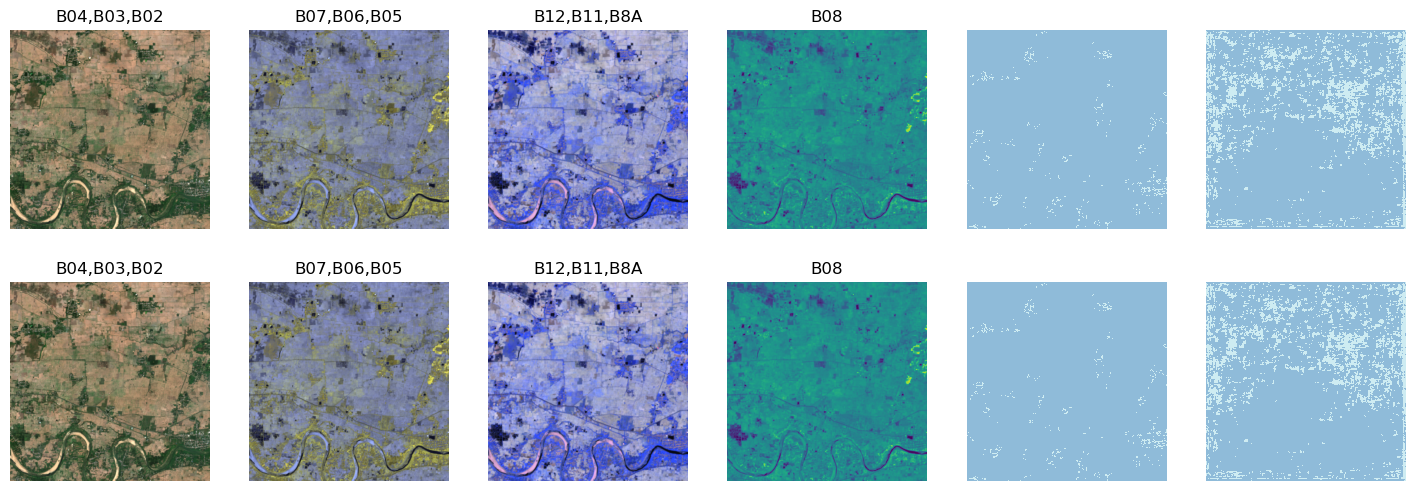

In [ ]:
#| notest
learner = fastgs.create_unet_learner(dl, resnet18,reweight="avg") # weights of n > 3 channels are set to average of first 3 channels
learner.fit_one_cycle(1)
learner.show_results(mskovl=False)

Finally, we can look at the top losses

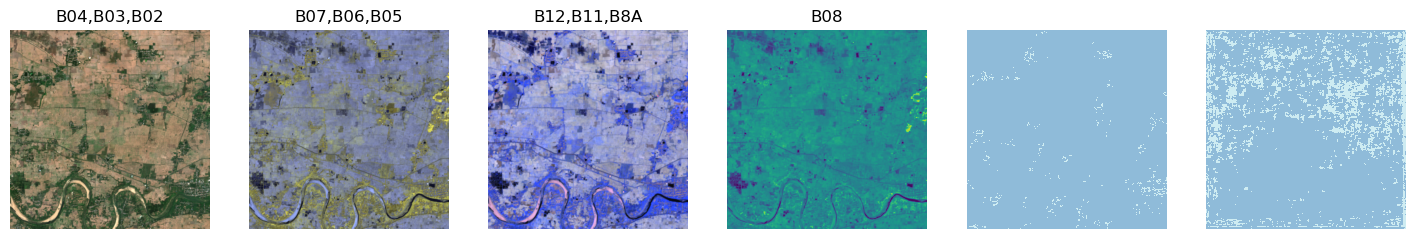

In [ ]:
#| notest
interp = SegmentationInterpretation.from_learner(learner)
interp.plot_top_losses(k=1,mskovl=False)

## Acknowledgements

This library is inspired by the following notebooks (and related works by the authors)

* [@cordmaur](https://github.com/cordmaur) - Mauricio Cordeiro's [multi-spectral segmentation fastai pipeline](https://www.kaggle.com/code/cordmaur/remotesensing-fastai2-multiband-augmentations/notebook)
* [@wrignj08](https://github.com/wrignj08) - Nick Wright's [multi-spectral classification notebook](https://dpird-dma.github.io/blog/Multispectral-image-classification-Transfer-Learning//)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()